<a href="https://colab.research.google.com/github/PLONTZNathan/MachineLearning_Assignment1/blob/elena/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/X_train.csv'
train = pd.read_csv(file_path)
file_path_2 = '/content/drive/MyDrive/X_test.csv'
test = pd.read_csv(file_path_2)

Mounted at /content/drive


**DATASET CLEANED**

In [3]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [4]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

In [5]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [6]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [7]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [8]:
train_cleaned = remove_collision(train_cleaned)

In [9]:
def split_trajectories(df,
                                train_size=0.6,
                                validation_size=0.2,
                                test_size=0.2,
                                method="random",
                                random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Identifier les indices de début de trajectoire
    traj_start_indices = df.index[df['t'] == 0].tolist()
    traj_start_indices.append(len(df))  # ajouter la fin pour le dernier bloc

    # Construire les slices de trajectoires
    traj_slices = [(traj_start_indices[i], traj_start_indices[i+1]) for i in range(len(traj_start_indices)-1)]

    if method == "random":
        np.random.shuffle(traj_slices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_traj = len(traj_slices)
    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si reste
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining

    train_slices = traj_slices[:n_train]
    val_slices = traj_slices[n_train:n_train+n_val]
    test_slices = traj_slices[n_train+n_val:n_train+n_val+n_test]

    # Concaténer les DataFrames correspondants
    train_df = pd.concat([df.iloc[start:end] for start, end in train_slices])
    val_df = pd.concat([df.iloc[start:end] for start, end in val_slices])
    test_df = pd.concat([df.iloc[start:end] for start, end in test_slices])

    return train_df, val_df, test_df


In [10]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [12]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]
y_train = train_after_split[target_cols]

pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [14]:
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline.predict(X_val)

X_test = test_entry[input_cols]
y_test= test_after_split[target_cols]

y_pred_test = pipeline.predict(X_test)

In [11]:
def replicate_initial_position_by_block(df):
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]

    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values

    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc

    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée


    copy[coords] = data
    return copy

**FEATURE ENGINEERING**

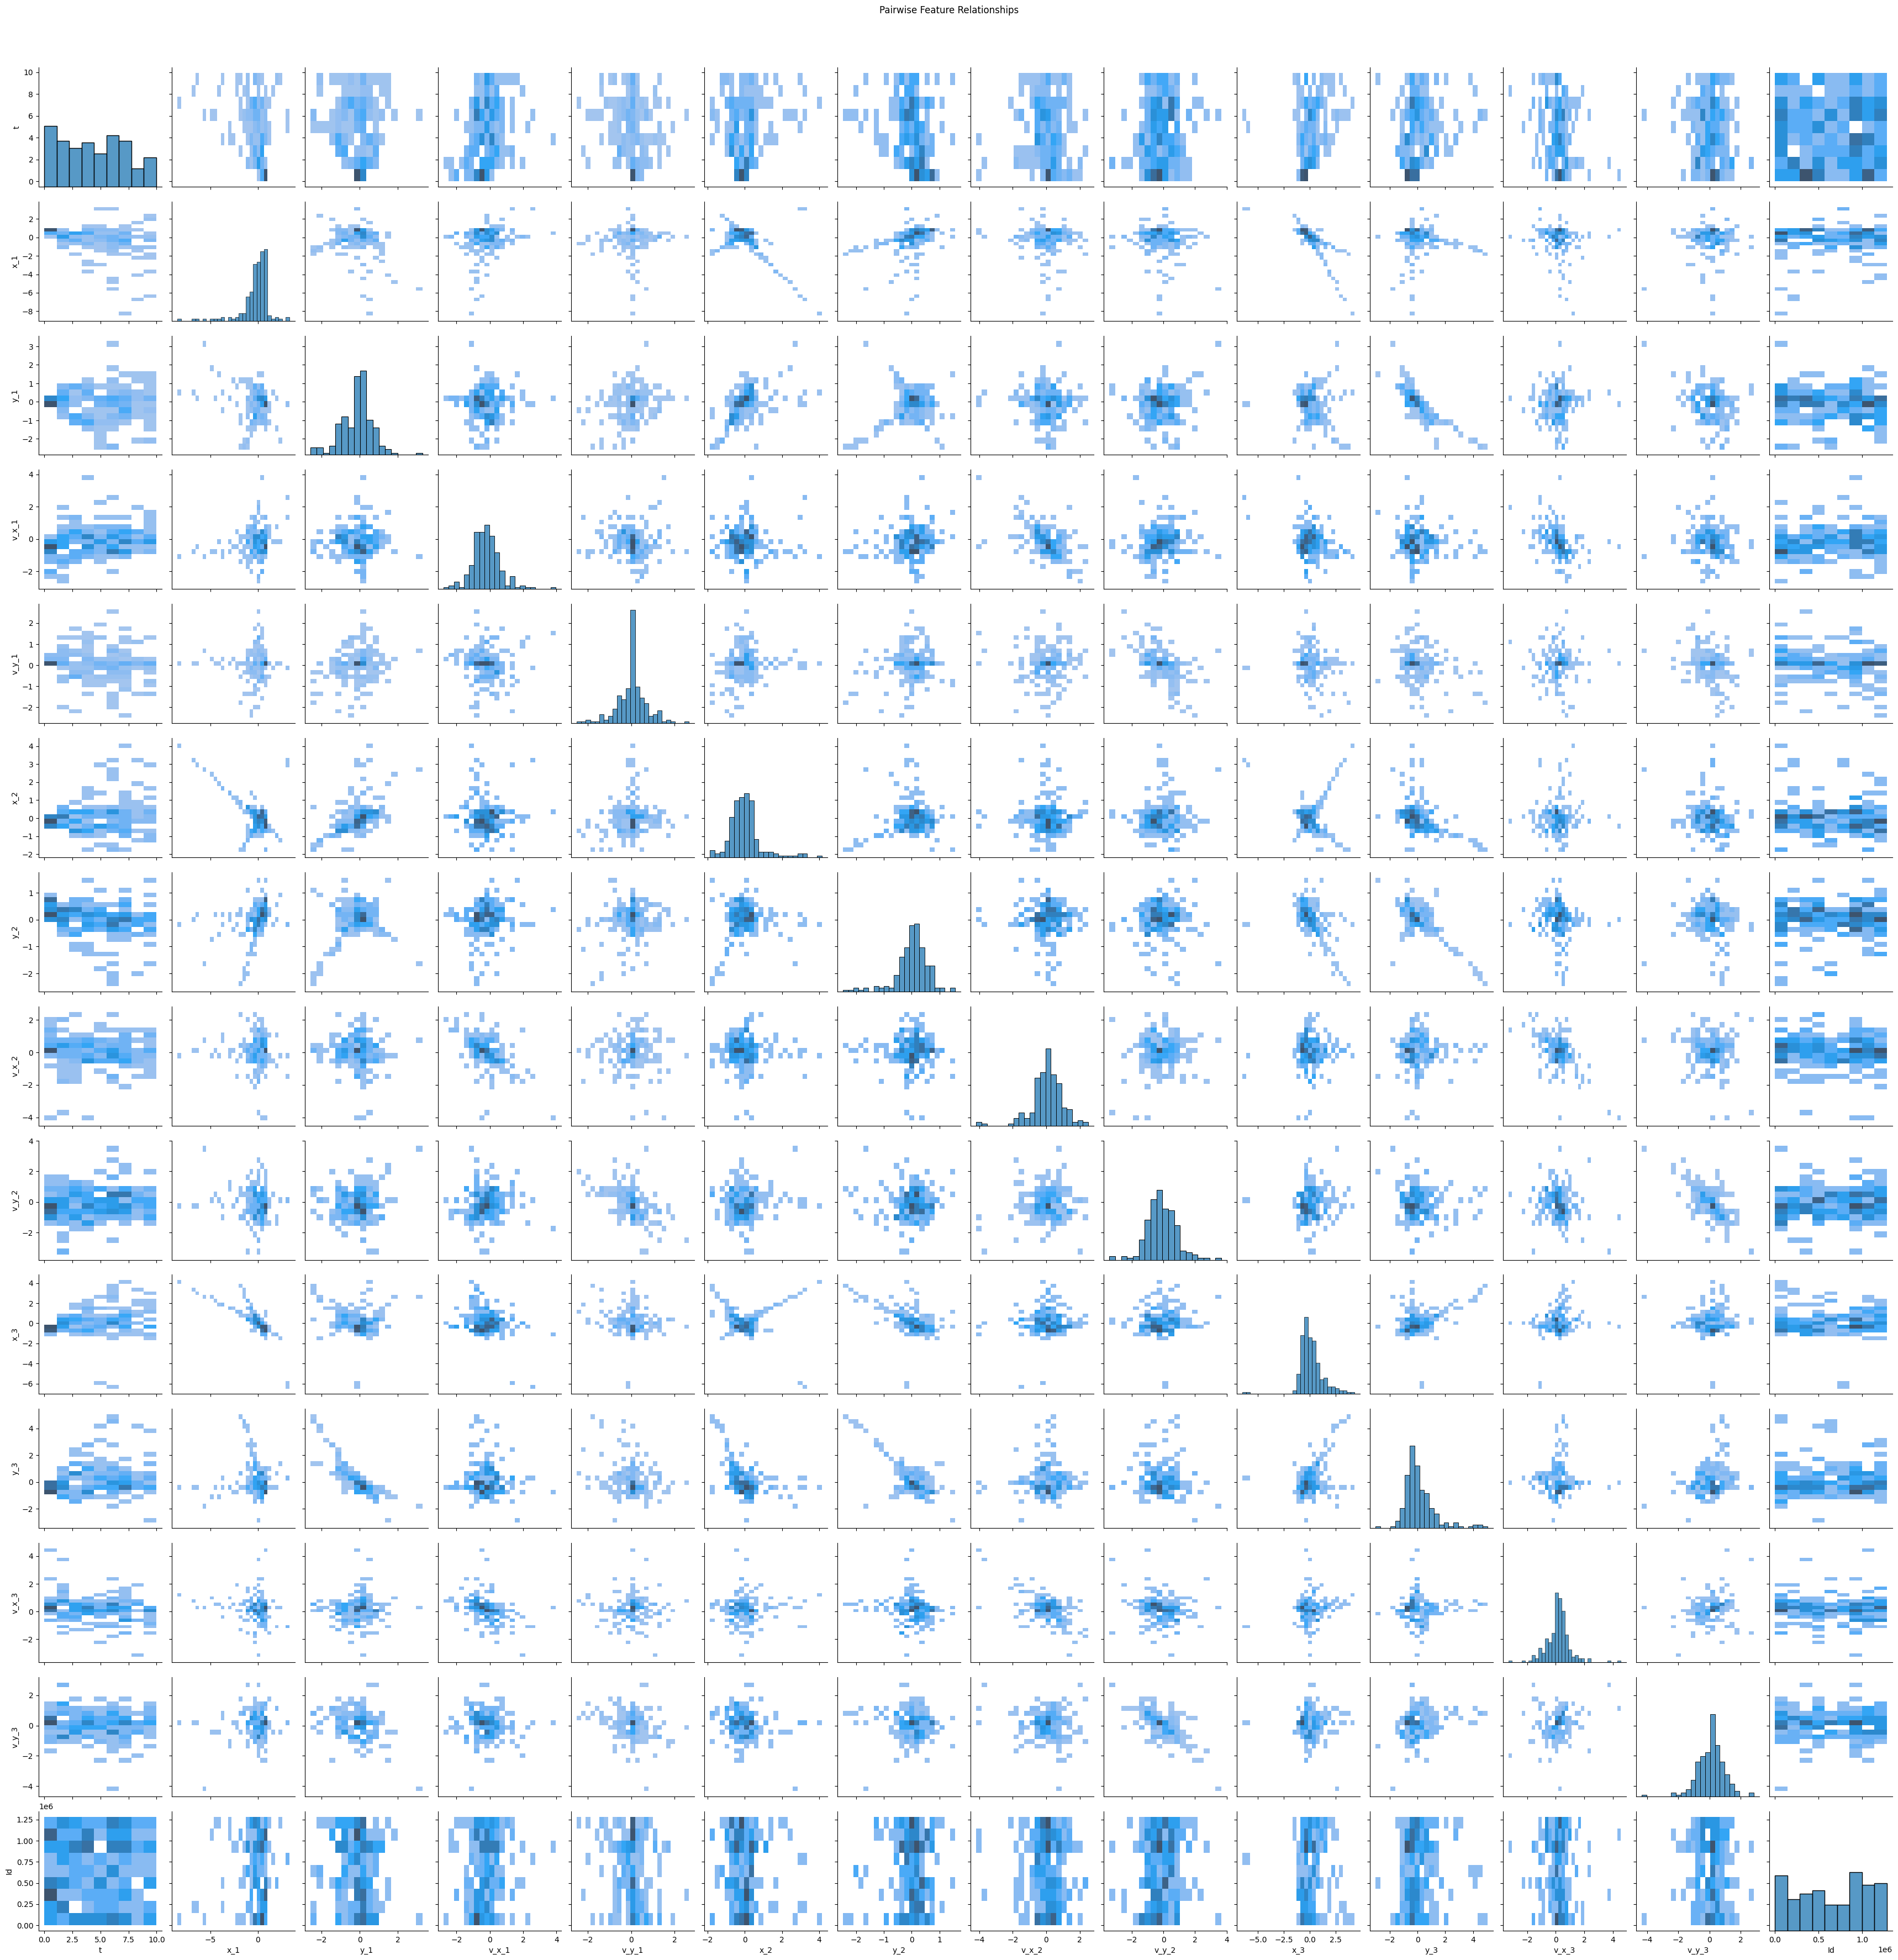

In [16]:
# Explore pairwise relationships
import seaborn as sns
sns.pairplot(train_after_split.sample(200, random_state=42), kind="hist")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

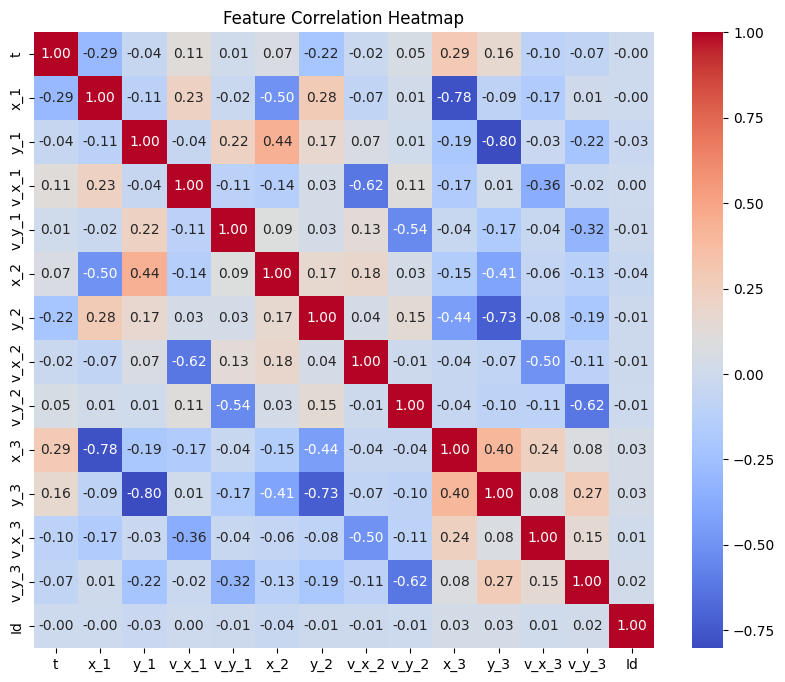

Highly correlated feature pairs:

   Feature_1 Feature_2  Correlation  abs_corr
32       y_1       y_3    -0.802460  0.802460
20       x_1       x_3    -0.780918  0.780918
66       y_2       y_3    -0.725060  0.725060
79     v_y_2     v_y_3    -0.623629  0.623629
39     v_x_1     v_x_2    -0.623117  0.623117
49     v_y_1     v_y_2    -0.539523  0.539523
73     v_x_2     v_x_3    -0.500864  0.500864
16       x_1       x_2    -0.500483  0.500483
27       y_1       x_2     0.441589  0.441589
65       y_2       x_3    -0.440624  0.440624


In [18]:
#Compute the correlation matrix
corr = train_after_split.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify pairs with high correlation
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
)

# Sort by absolute correlation descending
corr_pairs["abs_corr"] = corr_pairs["Correlation"].abs()
corr_pairs = corr_pairs.sort_values("abs_corr", ascending=False)

print("Highly correlated feature pairs:\n")
print(corr_pairs.head(10))

FEATURE ENGINEERING (DROP BODY 3)

In [26]:
# Drop one body (body 3)
body_to_drop = 3
cols_to_drop = [f"x_{body_to_drop}", f"y_{body_to_drop}",
                f"v_x_{body_to_drop}", f"v_y_{body_to_drop}"]

X_train_reduced = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val_reduced   = X_val.drop(columns=cols_to_drop, errors='ignore')

print(f"Removed body {body_to_drop} features: {cols_to_drop}")
print("Reduced X_train shape:", X_train_reduced.shape)
print("Reduced X_val shape:", X_val_reduced.shape)

# Step 2: Fit linear model with reduced features
lin_reduced = LinearRegression()
lin_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = lin_reduced.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_pred_reduced))
print(f"RMSE (Reduced model - body {body_to_drop} removed): {rmse_reduced:.4f}")


Removed body 3 features: ['x_3', 'y_3', 'v_x_3', 'v_y_3']
Reduced X_train shape: (649356, 5)
Reduced X_val shape: (220715, 5)
RMSE (Reduced model - body 3 removed): 1.3919


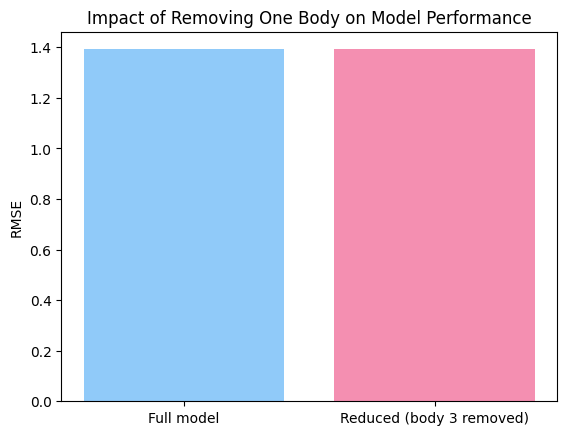

In [27]:
plt.bar(["Full model", f"Reduced (body {body_to_drop} removed)"],
        [rmse_full, rmse_reduced], color=["#90caf9", "#f48fb1"])
plt.ylabel("RMSE")
plt.title("Impact of Removing One Body on Model Performance")
plt.show()


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Full model (with all features)
lin_full = LinearRegression()
lin_full.fit(X_train, y_train)
y_pred_full = lin_full.predict(X_val)
rmse_full = np.sqrt(mean_squared_error(y_val, y_pred_full))
print(f"RMSE (Full model): {rmse_full:.4f}")

# Reduced model (after dropping velocity features)
lin_reduced = LinearRegression()
lin_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = lin_reduced.predict(X_val[X_train_reduced.columns])
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_pred_reduced))
print(f"RMSE (Reduced model): {rmse_reduced:.4f}")

RMSE (Full model): 1.3919
RMSE (Reduced model): 1.3919


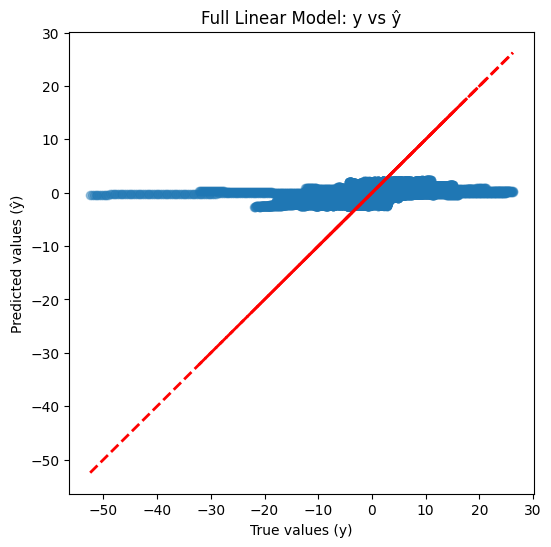

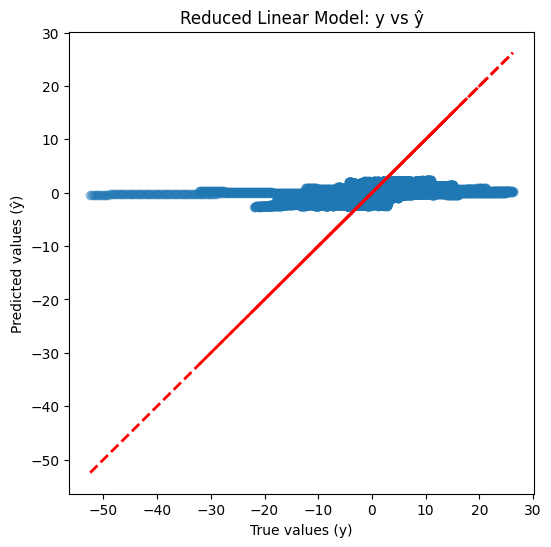

ΔRMSE = 0.0000
→ Reduced model performs comparably or better.


In [30]:
#plot y vs yhat
def plot_y_yhat(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2)
    plt.xlabel("True values (y)")
    plt.ylabel("Predicted values (ŷ)")
    plt.title(title)
    plt.show()

plot_y_yhat(y_val, y_pred_full, "Full Linear Model: y vs ŷ")
plot_y_yhat(y_val, y_pred_reduced, "Reduced Linear Model: y vs ŷ")

# Comparison summary RMSE
print(f"ΔRMSE = {rmse_reduced - rmse_full:.4f}")
if rmse_reduced > rmse_full:
    print("→ Feature removal slightly worsened the performance.")
else:
    print("→ Reduced model performs comparably or better.")

I TRIED FEATURE ENGINEERING WITH DROPPING VELOCITY FEATURES BUT NO SENSE...

Since all correlations are below 0.8, we decide to keep them; however, based on our prior physical knowledge (v = dx/dt), we know that velocity is derived from position and time, so we retain position and time and remove velocity features.

Removed velocity features: ['v_x_1', 'v_x_2', 'v_x_3', 'v_y_1', 'v_y_2', 'v_y_3']
Reduced shape: (649356, 8)


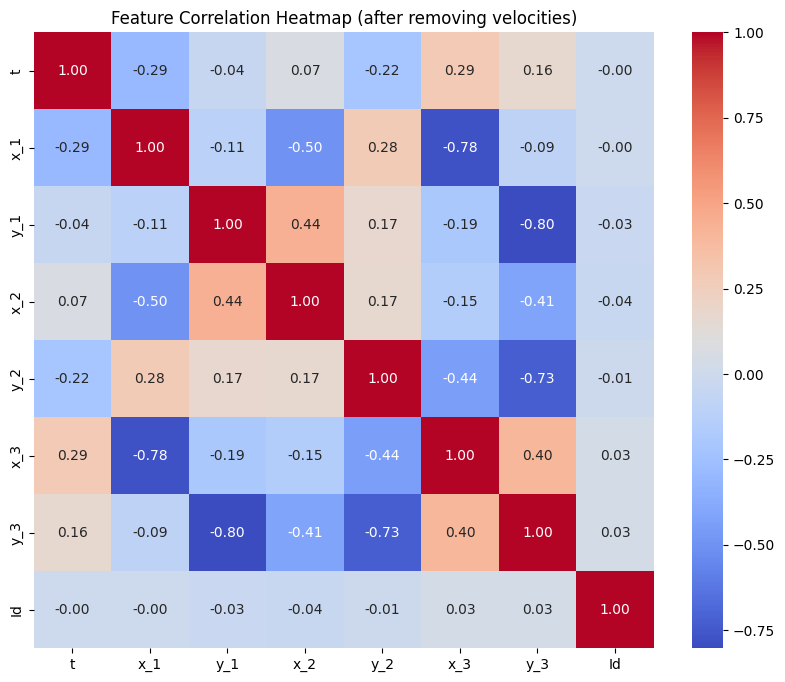


Top correlated feature pairs (after removing velocities):


,Feature_1,Feature_2,Correlation,AbsCorrelation
16,y_1,y_3,-0.802460,0.802460
10,x_1,x_3,-0.780918,0.780918
23,y_2,y_3,-0.725060,0.725060
8,x_1,x_2,-0.500483,0.500483
13,y_1,x_2,0.441589,0.441589
22,y_2,x_3,-0.440624,0.440624
20,x_2,y_3,-0.410967,0.410967
25,x_3,y_3,0.402250,0.402250
0,t,x_1,-0.292938,0.292938
4,t,x_3,0.287631,0.287631


In [21]:
# drop velocity features
cols_to_drop = [f"v_x_{i}" for i in [1,2,3]] + [f"v_y_{i}" for i in [1,2,3]]
X_train_reduced = train_after_split.drop(columns=cols_to_drop, errors='ignore')

print(f"Removed velocity features: {cols_to_drop}")
print("Reduced shape:", X_train_reduced.shape)

# Visualize correlations without velocities
plt.figure(figsize=(10,8))
corr_matrix = X_train_reduced.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (after removing velocities)")
plt.show()

# List the strongest correlations (sorted)
# Get upper triangle of the correlation matrix (to avoid duplicates)
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

# Sort by absolute correlation
corr_pairs["AbsCorrelation"] = corr_pairs["Correlation"].abs()
corr_pairs_sorted = corr_pairs.sort_values(by="AbsCorrelation", ascending=False)

print("\nTop correlated feature pairs (after removing velocities):")
display(corr_pairs_sorted.head(15))



In [23]:
# Reduced model (after dropping velocity features)
cols_to_drop = [f"v_x_{i}" for i in [1,2,3]] + [f"v_y_{i}" for i in [1,2,3]]

X_train_reduced = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val_reduced   = X_val.drop(columns=cols_to_drop, errors='ignore')

lin_reduced = LinearRegression()
lin_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = lin_reduced.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_pred_reduced))
print(f"RMSE (Reduced model): {rmse_reduced:.4f}")


RMSE (Reduced model): 1.3919


COMPARE FULL_MODEL VS REDUCED MODEL (after feature engineering)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Full model (with all features)
lin_full = LinearRegression()
lin_full.fit(X_train, y_train)
y_pred_full = lin_full.predict(X_val)
rmse_full = np.sqrt(mean_squared_error(y_val, y_pred_full))
print(f"RMSE (Full model): {rmse_full:.4f}")

# Reduced model (after dropping velocity features)
lin_reduced = LinearRegression()
lin_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = lin_reduced.predict(X_val[X_train_reduced.columns])
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_pred_reduced))
print(f"RMSE (Reduced model): {rmse_reduced:.4f}")


RMSE (Full model): 1.3919
RMSE (Reduced model): 1.3919


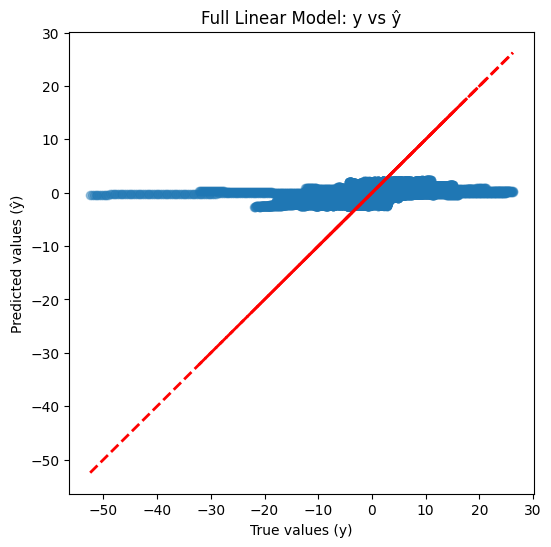

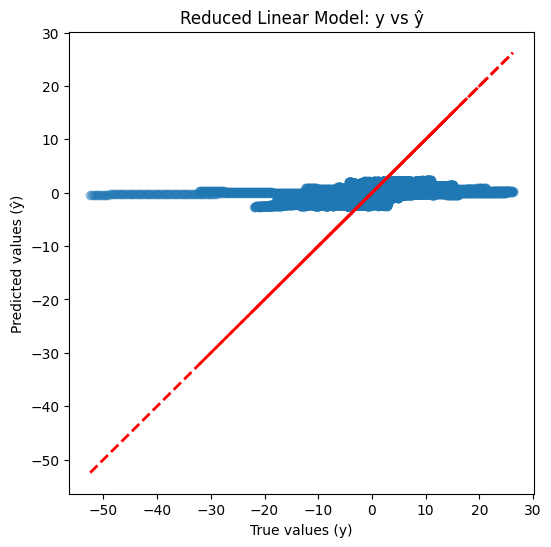

ΔRMSE = 0.0000
→ Reduced model performs comparably or better.


In [25]:
#plot y vs yhat
def plot_y_yhat(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2)
    plt.xlabel("True values (y)")
    plt.ylabel("Predicted values (ŷ)")
    plt.title(title)
    plt.show()

plot_y_yhat(y_val, y_pred_full, "Full Linear Model: y vs ŷ")
plot_y_yhat(y_val, y_pred_reduced, "Reduced Linear Model: y vs ŷ")

# Comparison summary RMSE
print(f"ΔRMSE = {rmse_reduced - rmse_full:.4f}")
if rmse_reduced > rmse_full:
    print("→ Feature removal slightly worsened the performance.")
else:
    print("→ Reduced model performs comparably or better.")


In [ ]:
#polynomial model


In [ ]:
#feature augmentation

In [ ]:
#Re-evaluate Linear and Polynomial Models with Augmented Features